In [1]:
%load_ext autoreload
%load_ext autotime
%autoreload 2

## Imports

In [238]:
# importing packages
import os, sys
import pandas as pd
import numpy as np
import warnings

# setting project path
gparent = os.path.join(os.pardir, os.pardir)
sys.path.append(gparent)

from IPython.display import Audio
sound_file = '/Users/dsbox/Documents/Flatiron/phase_5/WAILERLP.wav'

from src import helper_functions as f
from src import visualizations as v
from src import class_Database as d
from src import class_Harness as h

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.pipeline import make_pipeline 
from sklearn.metrics import (accuracy_score, recall_score, precision_score,
                             f1_score, make_scorer, confusion_matrix)
from sklearn.dummy import DummyClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC 
from sklearn.tree import DecisionTreeClassifier, export_graphviz, plot_tree
from sklearn.ensemble import (BaggingClassifier, AdaBoostClassifier,
                              RandomForestClassifier, VotingClassifier)
import xgboost as xgb
from xgboost import XGBClassifier, plot_importance

from keras import layers, models, optimizers, losses, metrics
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier

import matplotlib.pyplot as plt
import seaborn as sns
import graphviz
%matplotlib inline

sns.set_theme('talk')
plt.style.use('fivethirtyeight')
sns.set_palette("winter_r")
pd.options.display.max_rows = 300

time: 4.58 ms


## Creating The Database

In [3]:
# creating database & database class instance
database_name = 'outcomes.db'
db = d.Database(database_name)

time: 1.34 ms


**Run The Cell Below Once And Then Comment Out**

In [4]:
# file_name = 'anonymisedData.zip'
# db.populate(file_name, database_name)

time: 575 µs


### Database ERD

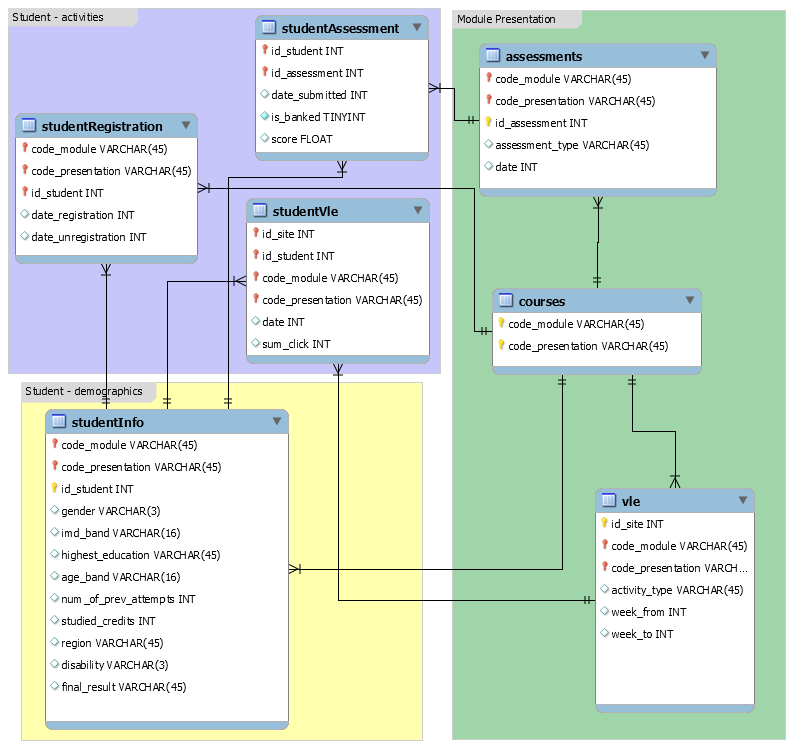

time: 4.16 ms


In [5]:
db.erd

## Preprocessing and Harness Objects

In [6]:
string_selector = make_column_selector(dtype_include='object')
number_selector = make_column_selector(dtype_include='number', dtype_exclude='object')

preprocessing_ohe = make_column_transformer((OneHotEncoder
                                         (handle_unknown='ignore'),string_selector))
preprocessing_ss = make_column_transformer((OneHotEncoder
                                         (handle_unknown='ignore'),string_selector),
                                          (StandardScaler(), number_selector))
preprocessing_mm = make_column_transformer((OneHotEncoder
                                         (handle_unknown='ignore'),string_selector),
                                          (MinMaxScaler(), number_selector))

time: 1.47 ms


In [7]:
# creating accuracy scorer
accuracy = f.acc_score

# creating f1 scorer
f1 = f.f1

# creating recall scorer 
recall = f.recall

# creating precision scorer
precision = f.precision

# creating Harness
modeling = h.Harness(('accuracy', 'f1', 'recall', 'precision'))

time: 77.2 ms


# STUDENTINFO Table

In [8]:
db.table_info('STUDENTINFO')

[(0, 'code_module', 'TEXT', 0, None, 0),
 (1, 'code_presentation', 'TEXT', 0, None, 0),
 (2, 'id_student', 'TEXT', 0, None, 0),
 (3, 'gender', 'TEXT', 0, None, 0),
 (4, 'region', 'TEXT', 0, None, 0),
 (5, 'highest_education', 'TEXT', 0, None, 0),
 (6, 'imd_band', 'TEXT', 0, None, 0),
 (7, 'age_band', 'TEXT', 0, None, 0),
 (8, 'num_of_prev_attempts', 'TEXT', 0, None, 0),
 (9, 'studied_credits', 'TEXT', 0, None, 0),
 (10, 'disability', 'TEXT', 0, None, 0),
 (11, 'final_result', 'TEXT', 0, None, 0)]

time: 3.2 ms


## Creating STUDENTINFO Data Frame

In [9]:
df = db.student_info()

time: 5.11 s


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31482 entries, 0 to 32592
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   target                31482 non-null  int64   
 1   code_module           31482 non-null  object  
 2   code_presentation     31482 non-null  object  
 3   gender                31482 non-null  object  
 4   region                31482 non-null  object  
 5   highest_education     31482 non-null  object  
 6   imd_band              31482 non-null  object  
 7   age_band              31482 non-null  object  
 8   num_of_prev_attempts  31482 non-null  object  
 9   disability            31482 non-null  object  
 10  course_load           31482 non-null  category
dtypes: category(1), int64(1), object(9)
memory usage: 2.7+ MB
time: 22.9 ms


In [11]:
df.target.value_counts(normalize=True)

0    0.534496
1    0.465504
Name: target, dtype: float64

time: 4.55 ms


## Creating Holdout Data

In [12]:
# splitting data & target
X, y = f.X_y(df)

time: 4.27 ms


In [13]:
# splitting training and holdout data
X_training, X_holdout, y_training, y_holdout = f.test_train(X, y)

time: 18.5 ms


## Creating Training Data

In [14]:
X_train, X_test, y_train, y_test = f.test_train(X_training, y_training)

time: 13.6 ms


## Baseline Model: Dummy Classifier

In [15]:
dummy = DummyClassifier(strategy='most_frequent')

time: 709 µs


In [16]:
baseline = make_pipeline(preprocessing_ohe, dummy)

time: 832 µs


### Fitting Model

In [17]:
baseline.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10ad70190>)])),
                ('dummyclassifier', DummyClassifier(strategy='most_frequent'))])

time: 83.4 ms


### Saving Model

In [18]:
# f.pickle_model(baseline, 'baseline')

time: 663 µs


### Cross Val Scores

In [19]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    modeling.report(baseline, X_train, y_train, ' Baseline', 'Baseline DummyCFL')

 Baseline has an average Accuracy of 0.5345041891301239
 Baseline has an average F1 of 0.0
 Baseline has an average Recall of 0.0
 Baseline has an average Precision of 0.0
time: 358 ms


### Test Data Confusion Matrix

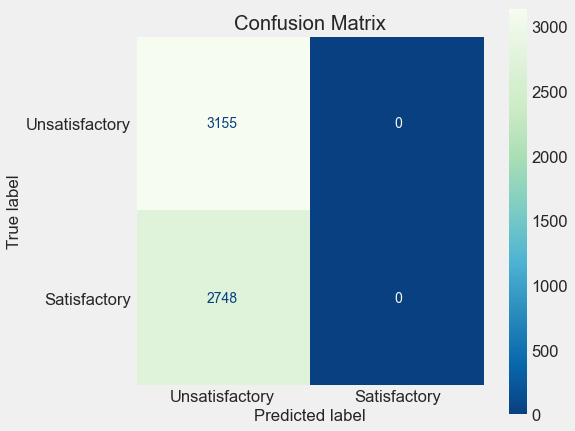

,Accuracy,F1,Recall,Precision
0,0.534474,0.0,0.0,0.0


time: 397 ms


In [20]:
%%capture --no-display
f.confusion_report(baseline, X_test, y_test, 'baseline')

## First Simple Model: Naive Bayes Classifier

In [21]:
mnb = MultinomialNB()

time: 741 µs


In [22]:
fsm = make_pipeline(preprocessing_ohe, mnb)

time: 933 µs


### Fitting Model

In [23]:
fsm.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10ad70190>)])),
                ('multinomialnb', MultinomialNB())])

time: 73.5 ms


### Saving Model

In [24]:
# f.pickle_model(fsm, 'fsm')

time: 660 µs


### Cross Val Scores

In [25]:
# checking cross val scores
modeling.report(fsm, X_train, y_train, ' fsm', 'FSM Naive Bayes')

 fsm has an average Accuracy of 0.6135084516922121
 fsm has an average F1 of 0.5584750581520643
 fsm has an average Recall of 0.5252959280999958
 fsm has an average Precision of 0.5962668280260026
time: 379 ms


### Test Data Confusion Matrix

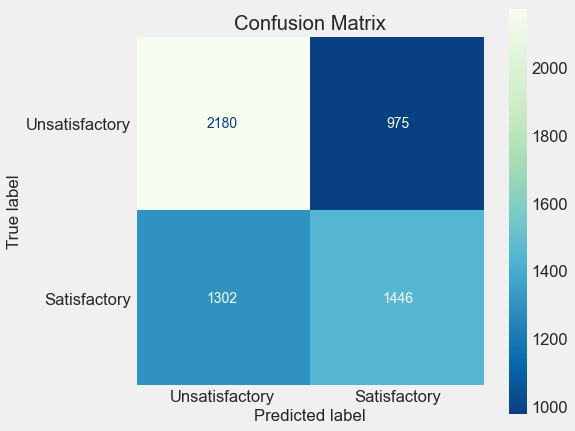

,Accuracy,F1,Recall,Precision
0,0.614264,0.559489,0.526201,0.597274


time: 356 ms


In [26]:
f.confusion_report(fsm, X_test, y_test, 'fsm')

## KNeighborsClassifier

In [27]:
KNN = KNeighborsClassifier(n_jobs=-1)

time: 785 µs


In [28]:
knn = make_pipeline(preprocessing_ohe, KNN)

time: 880 µs


### Fitting Model

In [29]:
knn.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10ad70190>)])),
                ('kneighborsclassifier', KNeighborsClassifier(n_jobs=-1))])

time: 83.2 ms


In [30]:
# f.pickle_model(knn, 'knn')

time: 633 µs


### Cross Val Scores

In [31]:
# checking cross val scores
modeling.report(knn, X_train, y_train, 'knn', 'KNN')

knn has an average Accuracy of 0.5628532009718852
knn has an average F1 of 0.5205299956194078
knn has an average Recall of 0.5097668048302295
knn has an average Precision of 0.5317915119904593
time: 9.17 s


### Test Data Confusion Matrix

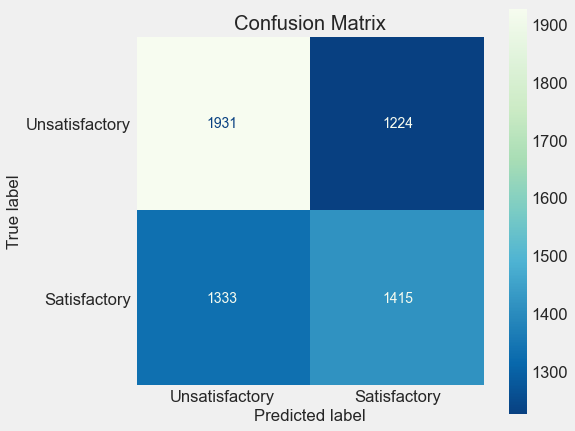

,Accuracy,F1,Recall,Precision
0,0.56683,0.525339,0.51492,0.536188


time: 20.2 s


In [32]:
f.confusion_report(knn, X_test, y_test)

## Logistic Regression Classifier

In [33]:
LR = LogisticRegression(max_iter=1000, n_jobs=-1, random_state = 2021, verbose=0)

time: 868 µs


In [34]:
logreg = make_pipeline(preprocessing_ohe, LR)

time: 929 µs


### Fitting Model

In [35]:
logreg.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10ad70190>)])),
                ('logisticregression',
                 LogisticRegression(max_iter=1000, n_jobs=-1,
                                    random_state=2021))])

time: 4.36 s


In [36]:
# f.pickle_model(logreg, 'logreg')

time: 727 µs


### Cross Val Scores

In [37]:
# checking cross val scores
modeling.report(logreg, X_train, y_train, 'logreg', 'Logistic Regression')

logreg has an average Accuracy of 0.6146943819045779
logreg has an average F1 of 0.5568065871980649
logreg has an average Recall of 0.5200780702632368
logreg has an average Precision of 0.5992637500035551
time: 7.53 s


### Test Data Confusion Matrix

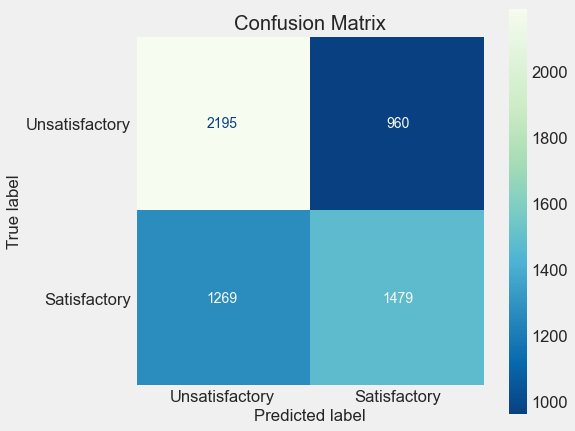

,Accuracy,F1,Recall,Precision
0,0.622395,0.570272,0.53821,0.606396


time: 257 ms


In [38]:
f.confusion_report(logreg, X_test, y_test)

## Support Vector Machine

In [39]:
SVC = SVC()

time: 714 µs


In [40]:
svc = make_pipeline(preprocessing_ohe, SVC)

time: 1.01 ms


### Fitting Model

In [41]:
svc.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10ad70190>)])),
                ('svc', SVC())])

time: 21.1 s


In [42]:
# f.pickle_model(svc, 'svc')

time: 575 µs


### Cross Val Scores

In [43]:
# checking cross val scores
modeling.report(svc, X_train, y_train, 'svc', 'Support Vector Classifier')

svc has an average Accuracy of 0.6105146759481693
svc has an average F1 of 0.5578897065175143
svc has an average Recall of 0.5280843200056522
svc has an average Precision of 0.5916273931245771
time: 1min 23s


### Test Data Confusion Matrix

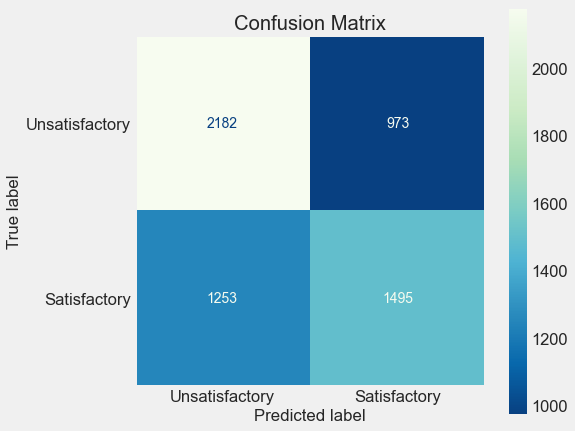

,Accuracy,F1,Recall,Precision
0,0.622904,0.573236,0.544032,0.605754


time: 26.5 s


In [44]:
f.confusion_report(svc, X_test, y_test)

## Linear Support Vector Machine

In [45]:
LSVC = LinearSVC()

time: 700 µs


In [46]:
lsvc = make_pipeline(preprocessing_ohe, LSVC)

time: 856 µs


### Fitting Model

In [47]:
lsvc.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10ad70190>)])),
                ('linearsvc', LinearSVC())])

time: 322 ms


In [48]:
# f.pickle_model(lsvc, 'lsvc')

time: 579 µs


### Cross Val Scores

In [49]:
# checking cross val scores
modeling.report(lsvc, X_train, y_train, 'lsvc', 'Linear SVC')

lsvc has an average Accuracy of 0.6148638415106988
lsvc has an average F1 of 0.55707916803772
lsvc has an average Recall of 0.5204421479331398
lsvc has an average Precision of 0.599423698144912
time: 1.37 s


### Test Data Confusion Matrix

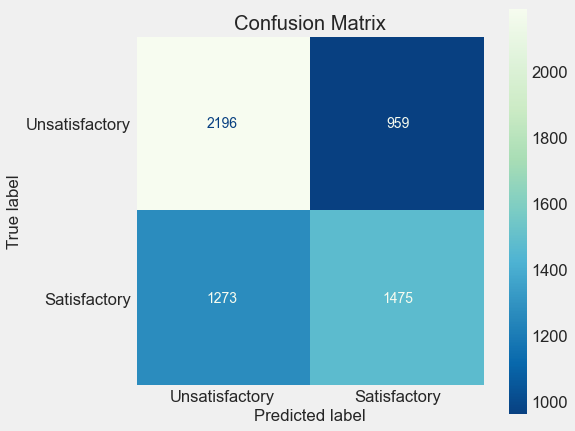

,Accuracy,F1,Recall,Precision
0,0.621887,0.569278,0.536754,0.605998


time: 260 ms


In [50]:
f.confusion_report(lsvc, X_test, y_test)

## Decision Tree

In [51]:
DT = DecisionTreeClassifier(random_state=2021)

time: 821 µs


In [52]:
dt = make_pipeline(preprocessing_ohe, DT)

time: 890 µs


### Fitting Model

In [53]:
dt.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10ad70190>)])),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(random_state=2021))])

time: 591 ms


In [54]:
# f.pickle_model(dt, 'dt')

time: 756 µs


### Cross Val Scores

In [55]:
# checking cross val scores
modeling.report(dt, X_train, y_train, 'dt', 'Decision Tree')

dt has an average Accuracy of 0.5409977913004569
dt has an average F1 of 0.47922863972403074
dt has an average Recall of 0.45383801303526117
dt has an average Precision of 0.507737322013517
time: 2.16 s


### Test Data Confusion Matrix

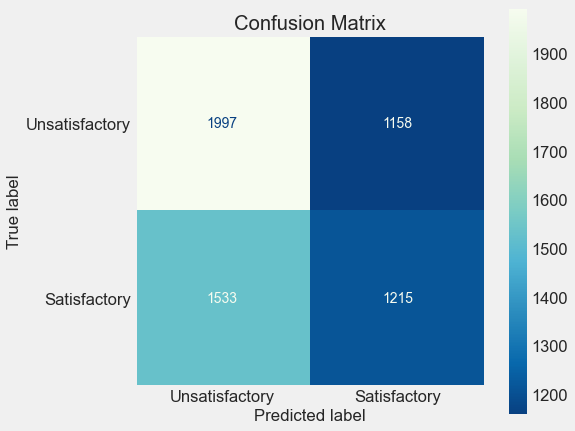

,Accuracy,F1,Recall,Precision
0,0.54413,0.474517,0.44214,0.51201


time: 277 ms


In [56]:
f.confusion_report(dt, X_test, y_test)

## Bagging Classifier

In [57]:
BCLF = BaggingClassifier(base_estimator=DT, random_state=2021)

time: 860 µs


In [58]:
bclf = make_pipeline(preprocessing_ohe, BCLF)

time: 1.01 ms


### Fitting Model

In [59]:
bclf.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10ad70190>)])),
                ('baggingclassifier',
                 BaggingClassifier(base_estimator=DecisionTreeClassifier(random_state=2021),
                                   random_state=2021))])

time: 3.8 s


In [60]:
# f.pickle_model(bclf, 'bclf')

time: 627 µs


### Cross Val Scores

In [61]:
# checking cross val scores
modeling.report(bclf, X_train, y_train, 'bclf', 'Bagging CLF')

bclf has an average Accuracy of 0.5551728553361597
bclf has an average F1 of 0.5054504013987768
bclf has an average Recall of 0.48841383715932574
bclf has an average Precision of 0.523763183365993
time: 14.1 s


### Test Data Confusion Matrix

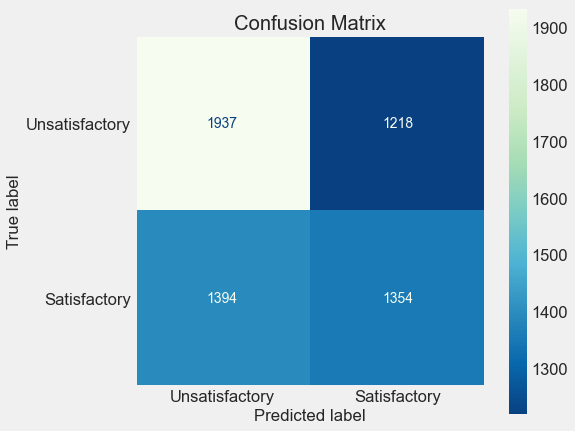

,Accuracy,F1,Recall,Precision
0,0.557513,0.509023,0.492722,0.526439


time: 327 ms


In [62]:
f.confusion_report(bclf, X_test, y_test)

## Random Forest Classifier

In [63]:
RF = RandomForestClassifier(n_jobs=-1, random_state=2021)

time: 821 µs


In [64]:
rf = make_pipeline(preprocessing_ohe, RF)

time: 829 µs


### Fitting Model

In [65]:
rf.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10ad70190>)])),
                ('randomforestclassifier',
                 RandomForestClassifier(n_jobs=-1, random_state=2021))])

time: 3.8 s


In [66]:
# f.pickle_model(rf, 'rf')

time: 657 µs


### Cross Val Scores

In [67]:
# checking cross val scores
modeling.report(rf, X_train, y_train, 'rf', 'Random Forest')

rf has an average Accuracy of 0.5697426500663121
rf has an average F1 of 0.5263073651414387
rf has an average Recall of 0.5135257761397021
rf has an average Precision of 0.5398162966900563
time: 17.9 s


### Test Data Confusion Matrix

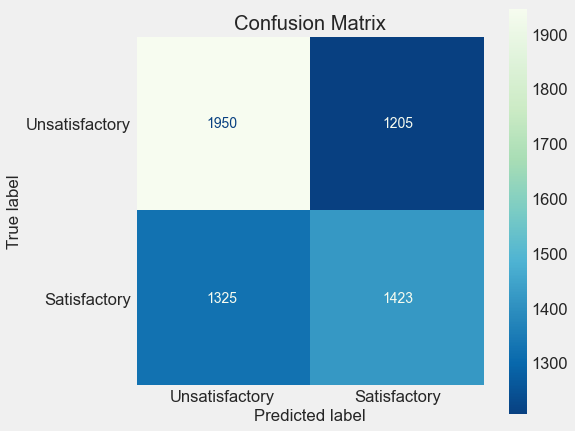

,Accuracy,F1,Recall,Precision
0,0.571574,0.529663,0.517831,0.541476


time: 604 ms


In [68]:
f.confusion_report(rf, X_test, y_test)

## AdaBoost

In [69]:
ADA = AdaBoostClassifier(base_estimator=DT, random_state=2021)

time: 802 µs


In [70]:
ada = make_pipeline(preprocessing_ohe, ADA)

time: 1.04 ms


### Fitting Model

In [71]:
ada.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10ad70190>)])),
                ('adaboostclassifier',
                 AdaBoostClassifier(base_estimator=DecisionTreeClassifier(random_state=2021),
                                    random_state=2021))])

time: 2.91 s


In [72]:
# f.pickle_model(ada, 'ada')

time: 591 µs


### Cross Val Scores

In [73]:
# checking cross val scores
modeling.report(ada, X_train, y_train, 'ada', 'AdaBoost')

ada has an average Accuracy of 0.5484527063864759
ada has an average F1 of 0.5026499071816447
ada has an average Recall of 0.4903547015843671
ada has an average Precision of 0.5158005143979636
time: 12.7 s


### Test Data Confusion Matrix

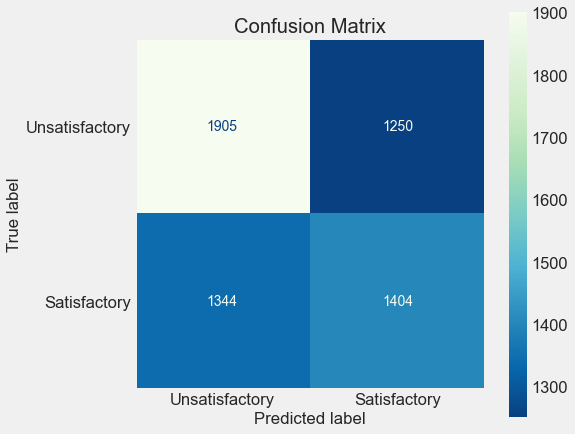

,Accuracy,F1,Recall,Precision
0,0.560562,0.519807,0.510917,0.529013


time: 451 ms


In [74]:
f.confusion_report(ada, X_test, y_test)

## XGBoost

In [75]:
XGB = XGBClassifier(use_label_encoder=False)

time: 865 µs


In [76]:
xgb = make_pipeline(preprocessing_ohe, XGB)

time: 1.06 ms


### Fitting Model

In [77]:
%%capture --no-display
xgb.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10ad70190>)])),
                ('xgbclassifier',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, gamma=0, gpu_id=-1,
                               impo...pe='gain',
                               interaction_constraints='',
                               learning_rate=0.300000012, max_delta_step=0,
                               max_depth=6, min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=100,
                               n_jobs=8, num_parallel_tree=1, random_state=0,
            

time: 972 ms


In [78]:
# f.pickle_model(xgb, 'xgb')

time: 2.32 ms


### Cross Val Scores

In [79]:
%%capture --no-display
# checking cross val scores
modeling.report(xgb, X_train, y_train, 'xgb', 'XGBoost')

time: 3.62 s


### Test Data Confusion Matrix

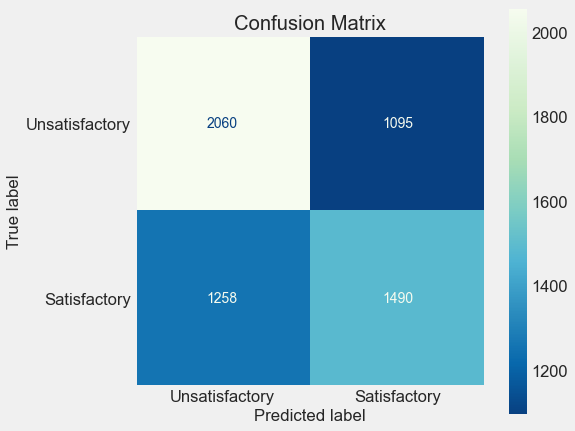

,Accuracy,F1,Recall,Precision
0,0.601389,0.558785,0.542213,0.576402


time: 410 ms


In [80]:
%%capture --no-display
f.confusion_report(xgb, X_test, y_test)

## Model Summary 1

In [81]:
modeling.history

,Name,Accuracy,F1,Recall,Precision,CV_Time(sec),Notes
0,Baseline,0.534504,0.000000,0.000000,0.000000,0.355226,Baseline DummyCFL
1,dt,0.540998,0.479229,0.453838,0.507737,2.154067,Decision Tree
2,ada,0.548453,0.502650,0.490355,0.515801,12.718576,AdaBoost
3,bclf,0.555173,0.505450,0.488414,0.523763,14.089840,Bagging CLF
4,knn,0.562853,0.520530,0.509767,0.531792,9.156851,KNN
5,rf,0.569743,0.526307,0.513526,0.539816,17.938879,Random Forest
10,xgb,0.589224,0.542735,0.523957,0.563241,3.612580,XGBoost
6,svc,0.610515,0.557890,0.528084,0.591627,83.341147,Support Vector Classifier
7,fsm,0.613508,0.558475,0.525296,0.596267,0.375140,FSM Naive Bayes
8,logreg,0.614694,0.556807,0.520078,0.599264,7.526850,Logistic Regression


time: 10.7 ms


# STUDENTINFO & STUDENTVLE

In [82]:
df = db.sv_si()

time: 38.1 s


In [83]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28174 entries, 0 to 29227
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   target                28174 non-null  int64   
 1   code_module           28174 non-null  object  
 2   code_presentation     28174 non-null  object  
 3   click_sum             28174 non-null  int64   
 4   num_activities        28174 non-null  int64   
 5   gender                28174 non-null  object  
 6   region                28174 non-null  object  
 7   highest_education     28174 non-null  object  
 8   imd_band              28174 non-null  object  
 9   age_band              28174 non-null  object  
 10  num_of_prev_attempts  28174 non-null  int64   
 11  disability            28174 non-null  object  
 12  course_load           28174 non-null  category
dtypes: category(1), int64(4), object(8)
memory usage: 2.8+ MB
time: 23 ms


In [84]:
df.head()

,target,code_module,code_presentation,click_sum,num_activities,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,disability,course_load
0,1,AAA,2013J,744,243,Male,Yorkshire Region,A Level or Equivalent,20-30%,0-35,0,No,Light
1,1,AAA,2013J,4104,913,Male,South Region,Lower Than A Level,80-90%,35-55,0,No,Light
2,1,AAA,2013J,1944,781,Male,North Western Region,A Level or Equivalent,30-40%,0-35,0,No,Light
3,1,AAA,2013J,1150,313,Male,London Region,HE Qualification,60-70%,0-35,0,No,Light
4,1,AAA,2013J,1896,572,Female,London Region,Lower Than A Level,30-40%,35-55,0,No,Light


time: 13.8 ms


In [85]:
df.describe()

,target,click_sum,num_activities,num_of_prev_attempts
count,28174.000000,28174.000000,28174.000000,28174.000000
mean,0.520054,1326.499219,356.832363,0.160006
std,0.499607,1713.634452,374.100510,0.475827
min,0.000000,1.000000,1.000000,0.000000
25%,0.000000,252.000000,91.000000,0.000000
50%,1.000000,717.000000,235.000000,0.000000
75%,1.000000,1722.000000,496.000000,0.000000
max,1.000000,24139.000000,3078.000000,6.000000


time: 19.9 ms


## Creating Holdout Data

In [86]:
# splitting data & target
X, y = f.X_y(df)

time: 7.22 ms


In [87]:
# splitting traing and holdout data
X_training, X_holdout, y_training, y_holdout = f.test_train(X, y)

time: 20 ms


## Creating Training Data

In [88]:
# train test split
X_train, X_test, y_train, y_test = f.test_train(X_training, y_training)

time: 18.8 ms


## MinMax Scaling
Since we've added numerical columns with very different scales to the data, we'll implement some scaling in the pipeline. K-Nearest Neighbors in particular is sensitive to differences in feature scale, and scaling can also help speed up convergence is certain algorithms.

## Naive Bayes Classifier

In [89]:
mnb_svsi = make_pipeline(preprocessing_mm, mnb)

time: 864 µs


### Fitting Model

In [90]:
mnb_svsi.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10ad70190>),
                                                 ('minmaxscaler',
                                                  MinMaxScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10ad70040>)])),
                ('multinomialnb', MultinomialNB())])

time: 90.8 ms


### Saving Model

In [91]:
# f.pickle_model(mnb_svsi, 'mnb_svsi')

time: 637 µs


### Cross Val Scores

In [92]:
# checking cross val scores
modeling.report(mnb_svsi, X_train, y_train, ' mnb_svsi', 'Naive Bayes SVSI/MinMax()')

 mnb_svsi has an average Accuracy of 0.6786766715808608
 mnb_svsi has an average F1 of 0.701241283960963
 mnb_svsi has an average Recall of 0.7252748061490635
 mnb_svsi has an average Precision of 0.6788375700243776
time: 431 ms


### Test Data Confusion Matrix

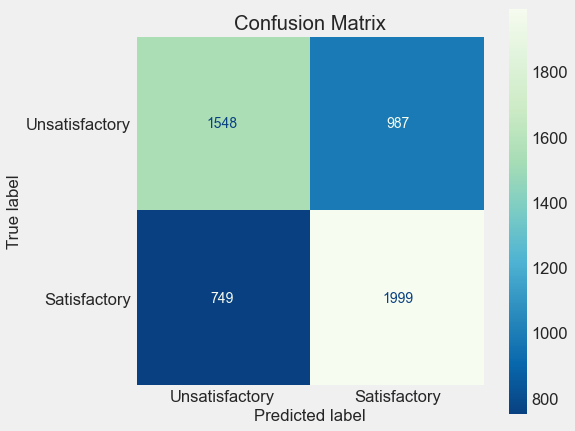

,Accuracy,F1,Recall,Precision
0,0.671399,0.697245,0.727438,0.669457


time: 284 ms


In [93]:
f.confusion_report(mnb_svsi, X_test, y_test)

## KNeighborsClassifier

In [94]:
knn_svsi = make_pipeline(preprocessing_mm, KNN)

time: 1.01 ms


### Fitting Model

In [95]:
knn_svsi.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10ad70190>),
                                                 ('minmaxscaler',
                                                  MinMaxScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10ad70040>)])),
                ('kneighborsclassifier', KNeighborsClassifier(n_jobs=-1))])

time: 78.6 ms


In [96]:
# f.pickle_model(knn_svsi, 'knn_svsi')

time: 692 µs


### Cross Val Scores

In [97]:
# checking cross val scores
modeling.report(knn_svsi, X_train, y_train, 'knn_svsi', 'KNN SVSI/MinMax()')

knn_svsi has an average Accuracy of 0.7280870379753388
knn_svsi has an average F1 of 0.7391469699856765
knn_svsi has an average Recall of 0.7408090075185314
knn_svsi has an average Precision of 0.7375013312332741
time: 9.69 s


### Test Data Confusion Matrix

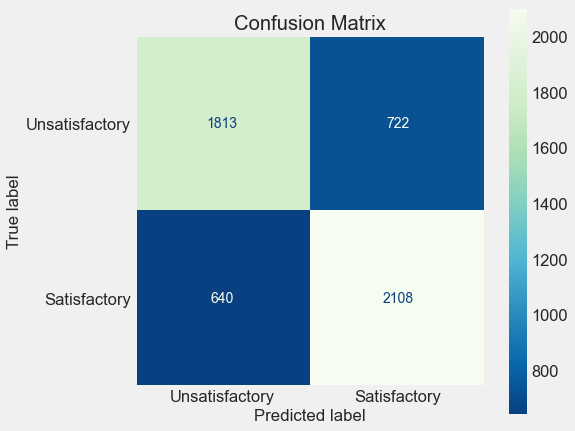

,Accuracy,F1,Recall,Precision
0,0.742192,0.755826,0.767103,0.744876


time: 20.8 s


In [98]:
f.confusion_report(knn_svsi, X_test, y_test)

## Logistic Regression Classifier

In [99]:
logreg_svsi = make_pipeline(preprocessing_mm, LR)

time: 974 µs


### Fitting Model

In [100]:
logreg_svsi.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10ad70190>),
                                                 ('minmaxscaler',
                                                  MinMaxScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10ad70040>)])),
                ('logisticregression',
                 LogisticRegression(max_iter=1000, n_jobs=-1,
                                    random_state=2021))])

time: 473 ms


In [101]:
# f.pickle_model(logreg_svsi, 'logreg_svsi')

time: 624 µs


### Cross Val Scores

In [102]:
# checking cross val scores
modeling.report(logreg_svsi, X_train, y_train, 'logreg_svsi', 'LogReg SVSI/MinMax()')

logreg_svsi has an average Accuracy of 0.8142865277087876
logreg_svsi has an average F1 of 0.8184801511385398
logreg_svsi has an average Recall of 0.8052417028266617
logreg_svsi has an average Precision of 0.8322252250837672
time: 1.42 s


### Test Data Confusion Matrix

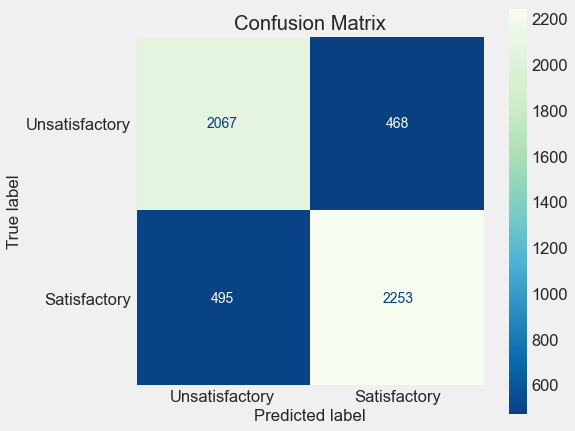

,Accuracy,F1,Recall,Precision
0,0.817717,0.823917,0.819869,0.828004


time: 320 ms


In [103]:
f.confusion_report(logreg_svsi, X_test, y_test)

## Support Vector Machine

In [104]:
svc_svsi= make_pipeline(preprocessing_mm, SVC)

time: 1.09 ms


### Fitting Model

In [105]:
svc_svsi.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10ad70190>),
                                                 ('minmaxscaler',
                                                  MinMaxScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10ad70040>)])),
                ('svc', SVC())])

time: 15.7 s


In [106]:
# f.pickle_model(svc, 'svc_svsi')

time: 763 µs


### Cross Val Scores

In [107]:
# checking cross val scores
modeling.report(svc_svsi, X_train, y_train, 'svc_svsi', 'Support Vector CLF SVSI/MinMax()')

svc_svsi has an average Accuracy of 0.784438542544942
svc_svsi has an average F1 of 0.7910783583129153
svc_svsi has an average Recall of 0.7847347171277679
svc_svsi has an average Precision of 0.7975555543908864
time: 1min


### Test Data Confusion Matrix

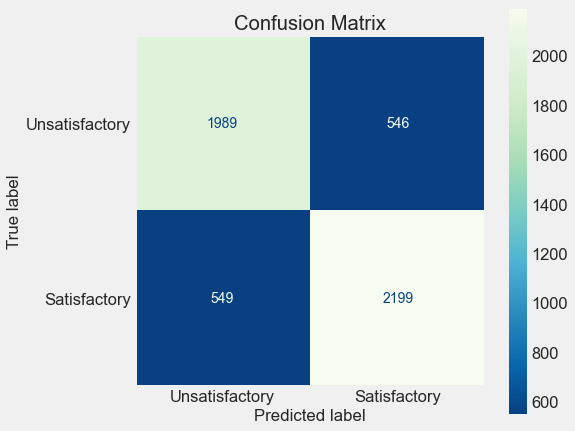

,Accuracy,F1,Recall,Precision
0,0.792731,0.800655,0.800218,0.801093


time: 18.4 s


In [108]:
f.confusion_report(svc_svsi, X_test, y_test)

## Linear Support Vector Machine

In [109]:
lsvc_svsi = make_pipeline(preprocessing_mm, LSVC)

time: 1.13 ms


### Fitting Model

In [110]:
lsvc_svsi.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10ad70190>),
                                                 ('minmaxscaler',
                                                  MinMaxScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10ad70040>)])),
                ('linearsvc', LinearSVC())])

time: 315 ms


In [111]:
# f.pickle_model(lsvc_svsi, 'lsvc_svsi')

time: 1.06 ms


### Cross Val Scores

In [112]:
# checking cross val scores
modeling.report(lsvc_svsi, X_train, y_train, 'lsvc_svsi', 'Linear SVC SVSI/MinMax()')

lsvc_svsi has an average Accuracy of 0.8126460097971974
lsvc_svsi has an average F1 of 0.8161024645428349
lsvc_svsi has an average Recall of 0.799538776074938
lsvc_svsi has an average Precision of 0.8334493246283519
time: 1.37 s


### Test Data Confusion Matrix

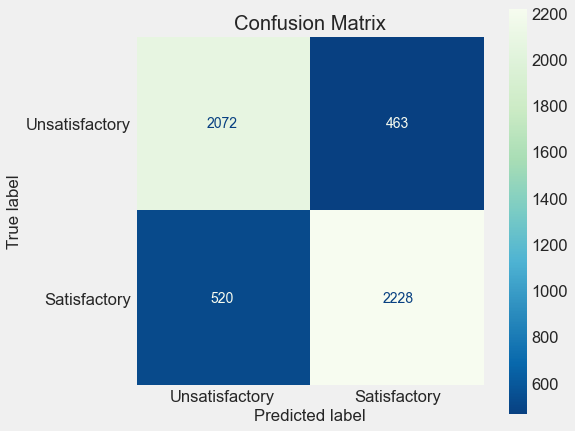

,Accuracy,F1,Recall,Precision
0,0.813931,0.819268,0.810771,0.827945


time: 331 ms


In [113]:
f.confusion_report(lsvc_svsi, X_test, y_test)

## Decision Tree

In [114]:
dt_svsi = make_pipeline(preprocessing_mm, DT)

time: 932 µs


### Fitting Model

In [115]:
dt_svsi.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10ad70190>),
                                                 ('minmaxscaler',
                                                  MinMaxScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10ad70040>)])),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(random_state=2021))])

time: 687 ms


In [116]:
# f.pickle_model(dt_svsi, 'dt_svsi')

time: 847 µs


### Cross Val Scores

In [117]:
# checking cross val scores
modeling.report(dt_svsi, X_train, y_train, 'dt_svsi', 'Decision Tree CLF SVSI/MinMax()')

dt_svsi has an average Accuracy of 0.7678423170839751
dt_svsi has an average F1 of 0.7764258626602372
dt_svsi has an average Recall of 0.7752705376014883
dt_svsi has an average Precision of 0.7777166568998316
time: 2.68 s


### Test Data Confusion Matrix

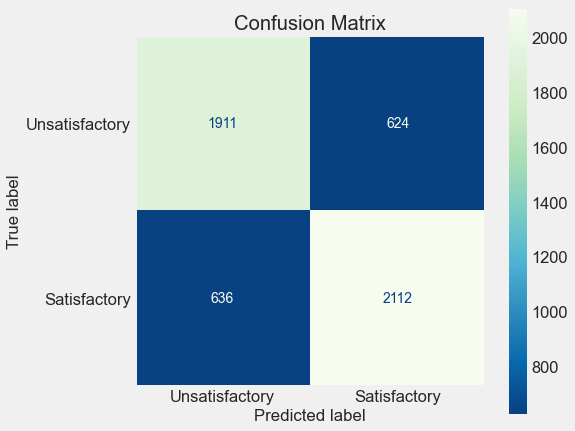

,Accuracy,F1,Recall,Precision
0,0.761499,0.770241,0.768559,0.77193


time: 301 ms


In [118]:
f.confusion_report(dt_svsi, X_test, y_test)

## Bagging Classifier

In [119]:
bclf_svsi = make_pipeline(preprocessing_mm, BCLF)

time: 1.16 ms


### Fitting Model

In [120]:
bclf_svsi.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10ad70190>),
                                                 ('minmaxscaler',
                                                  MinMaxScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10ad70040>)])),
                ('baggingclassifier',
                 BaggingClassifier(base_estimator=DecisionTreeClassifier(random_state=2021),
                                   random_state=2021))])

time: 3.93 s


In [121]:
# f.pickle_model(bclf_svsi, 'bclf_svsi')

time: 857 µs


### Cross Val Scores

In [122]:
# checking cross val scores
modeling.report(bclf_svsi, X_train, y_train, 'bclf_svsi', 'Bagging CLF SVSI/MinMax()')

bclf_svsi has an average Accuracy of 0.8081027063239803
bclf_svsi has an average F1 of 0.8160144135466766
bclf_svsi has an average Recall of 0.8182259621895
bclf_svsi has an average Precision of 0.8138526729148797
time: 14.6 s


### Test Data Confusion Matrix

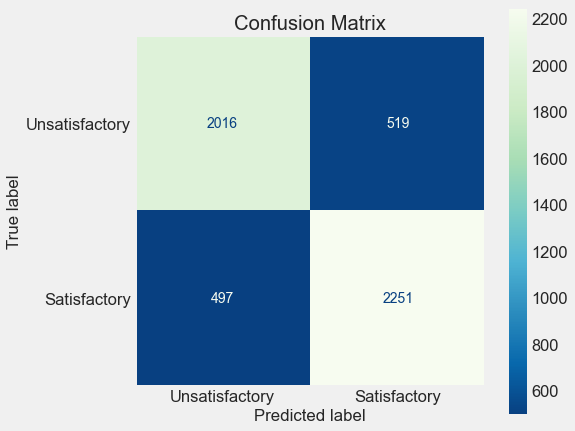

,Accuracy,F1,Recall,Precision
0,0.807685,0.815875,0.819141,0.812635


time: 379 ms


In [123]:
f.confusion_report(bclf_svsi, X_test, y_test)

## Random Forest Classifier

In [124]:
rf_svsi = make_pipeline(preprocessing_mm, RF)

time: 1.05 ms


### Fitting Model

In [125]:
rf_svsi.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10ad70190>),
                                                 ('minmaxscaler',
                                                  MinMaxScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10ad70040>)])),
                ('randomforestclassifier',
                 RandomForestClassifier(n_jobs=-1, random_state=2021))])

time: 3.52 s


In [126]:
# f.pickle_model(rf_svsi, 'rf_svsi')

time: 725 µs


### Cross Val Scores

In [127]:
# checking cross val scores
modeling.report(rf_svsi, X_train, y_train, 'rf_svsi', 'Random Forest SVSI/MinMax()')

rf_svsi has an average Accuracy of 0.8245725099121717
rf_svsi has an average F1 of 0.8372606217069951
rf_svsi has an average Recall of 0.8677348584314117
rf_svsi has an average Precision of 0.808875126638992
time: 15.8 s


### Test Data Confusion Matrix

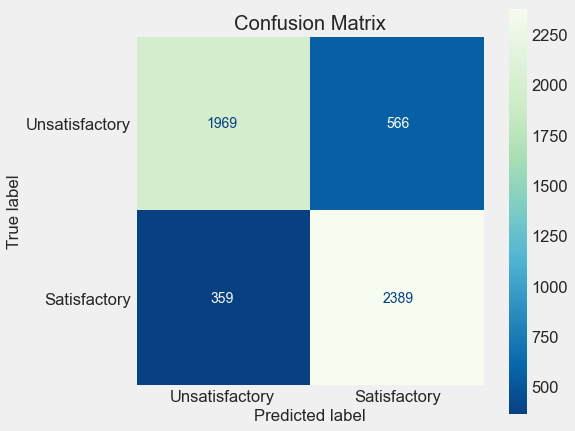

,Accuracy,F1,Recall,Precision
0,0.82491,0.837805,0.86936,0.80846


time: 685 ms


In [128]:
f.confusion_report(rf_svsi, X_test, y_test)

## AdaBoost

In [129]:
ada_svsi = make_pipeline(preprocessing_mm, ADA)

time: 1.04 ms


### Fitting Model

In [130]:
ada_svsi.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10ad70190>),
                                                 ('minmaxscaler',
                                                  MinMaxScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10ad70040>)])),
                ('adaboostclassifier',
                 AdaBoostClassifier(base_estimator=DecisionTreeClassifier(random_state=2021),
                                    random_state=2021))])

time: 704 ms


In [131]:
# f.pickle_model(ada_svsi, 'ada_svsi')

time: 859 µs


### Cross Val Scores

In [132]:
# checking cross val scores
modeling.report(ada_svsi, X_train, y_train, 'ada_svsi', 'AdaBoost SVSI/MinMax()')

ada_svsi has an average Accuracy of 0.7687887888685043
ada_svsi has an average F1 of 0.7776936776497783
ada_svsi has an average Recall of 0.777818566121274
ada_svsi has an average Precision of 0.7777347788903144
time: 2.76 s


### Test Data Confusion Matrix

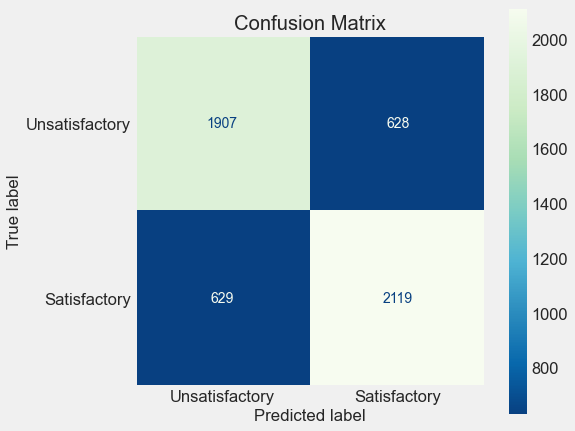

,Accuracy,F1,Recall,Precision
0,0.762067,0.771247,0.771106,0.771387


time: 331 ms


In [133]:
f.confusion_report(ada_svsi, X_test, y_test)

## XGBoost

In [134]:
xgb_svsi = make_pipeline(preprocessing_mm, XGB)

time: 1.02 ms


### Fitting Model

In [135]:
%%capture --no-display
xgb_svsi.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10ad70190>),
                                                 ('minmaxscaler',
                                                  MinMaxScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10ad70040>)])),
                ('xgbclassifier',
                 XGBClassifier(ba...
                               importance_type='gain',
                               interaction_constraints='',
                               learning_rate=0.300000012, max_delta_step=0,
                               max_depth=6, min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estima

time: 1.66 s


In [136]:
# f.pickle_model(xgb_svsi, 'xgb_svsi')

time: 797 µs


### Cross Val Scores

In [137]:
%%capture --no-display
# checking cross val scores
modeling.report(xgb_svsi, X_train, y_train, 'xgb_svsi', 'XGBoost SVSI/MinMax()')

time: 7.25 s


### Test Data Confusion Matrix

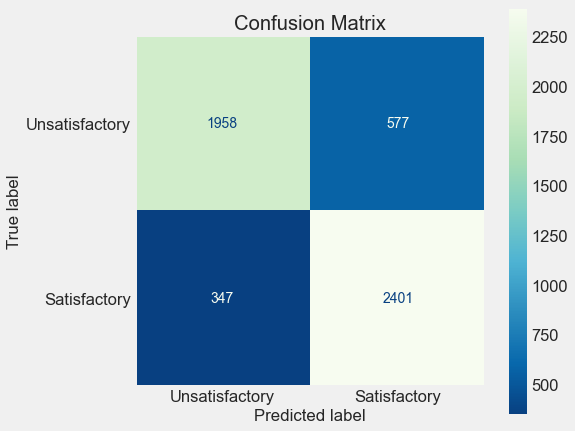

,Accuracy,F1,Recall,Precision
0,0.825099,0.838631,0.873726,0.806246


time: 507 ms


In [138]:
%%capture --no-display
f.confusion_report(xgb_svsi, X_test, y_test)

## Model Summary 2

In [139]:
modeling.history

,Name,Accuracy,F1,Recall,Precision,CV_Time(sec),Notes
0,Baseline,0.534504,0.000000,0.000000,0.000000,0.355226,Baseline DummyCFL
1,dt,0.540998,0.479229,0.453838,0.507737,2.154067,Decision Tree
2,ada,0.548453,0.502650,0.490355,0.515801,12.718576,AdaBoost
3,bclf,0.555173,0.505450,0.488414,0.523763,14.089840,Bagging CLF
4,knn,0.562853,0.520530,0.509767,0.531792,9.156851,KNN
5,rf,0.569743,0.526307,0.513526,0.539816,17.938879,Random Forest
6,xgb,0.589224,0.542735,0.523957,0.563241,3.612580,XGBoost
7,svc,0.610515,0.557890,0.528084,0.591627,83.341147,Support Vector Classifier
8,fsm,0.613508,0.558475,0.525296,0.596267,0.375140,FSM Naive Bayes
9,logreg,0.614694,0.556807,0.520078,0.599264,7.526850,Logistic Regression


time: 14.3 ms


## Voting Classifier
Using the top three model in a voting classifier.

In [140]:
clf1 = LR
clf2 = RF
clf3 = XGB

estimators = [('lsvs',clf1), ('logreg', clf1), ('rf', clf2), ('xgb', clf3)]

VC = VotingClassifier(estimators=estimators, voting='hard', n_jobs=-1)

time: 1.45 ms


In [141]:
vc_svsi = make_pipeline(preprocessing_mm, VC)

time: 1.02 ms


### Fitting Model

In [142]:
%%capture --no-display
vc_svsi.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10ad70190>),
                                                 ('minmaxscaler',
                                                  MinMaxScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10ad70040>)])),
                ('votingclassifier',
                 VotingClassif...
                                                             interaction_constraints='',
                                                             learning_rate=0.300000012,
                                                             max_delta_step=0,
                                                             max_depth=6,
   

time: 5.63 s


In [143]:
# f.pickle_model(vc_svsi, 'vc_svsi')

time: 1.29 ms


### Cross Val Scores

In [144]:
%%capture --no-display
# checking cross val scores
modeling.report(vc_svsi, X_train, y_train, 'vc_svsi', 'Voting CLF SVSI/MinMax()')

time: 23.3 s


### Test Data Confusion Matrix

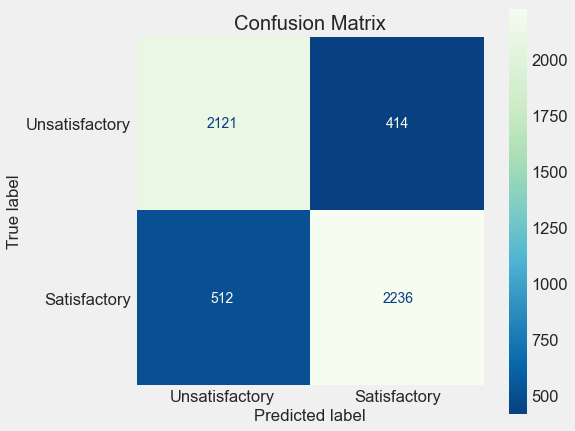

,Accuracy,F1,Recall,Precision
0,0.824721,0.828455,0.813683,0.843774


time: 972 ms


In [145]:
%%capture --no-display
f.confusion_report(vc_svsi, X_test, y_test)

## Model Summary 3

In [146]:
modeling.history

,Name,Accuracy,F1,Recall,Precision,CV_Time(sec),Notes
0,Baseline,0.534504,0.000000,0.000000,0.000000,0.355226,Baseline DummyCFL
1,dt,0.540998,0.479229,0.453838,0.507737,2.154067,Decision Tree
2,ada,0.548453,0.502650,0.490355,0.515801,12.718576,AdaBoost
3,bclf,0.555173,0.505450,0.488414,0.523763,14.089840,Bagging CLF
4,knn,0.562853,0.520530,0.509767,0.531792,9.156851,KNN
5,rf,0.569743,0.526307,0.513526,0.539816,17.938879,Random Forest
6,xgb,0.589224,0.542735,0.523957,0.563241,3.612580,XGBoost
7,svc,0.610515,0.557890,0.528084,0.591627,83.341147,Support Vector Classifier
8,fsm,0.613508,0.558475,0.525296,0.596267,0.375140,FSM Naive Bayes
9,logreg,0.614694,0.556807,0.520078,0.599264,7.526850,Logistic Regression


time: 13.2 ms


## Neural Network

### Create Model

In [147]:
def create_model():
    # building model
    model = Sequential()
    model.add(Dense(64, input_dim=49, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    # compiling
    model.compile(loss='binary_crossentropy',
                 optimizer='adam',
                 metrics=['accuracy'])
    return model

time: 1.42 ms


In [148]:
NN = KerasClassifier(build_fn=create_model,
                     epochs=10,
                     batch_size=32,
                     verbose=0)

time: 1.68 ms


### Pipeline

In [149]:
nn_svsi = make_pipeline(preprocessing_mm, NN)

time: 962 µs


### Fitting Models

In [150]:
%%capture --no-display
nn_svsi.fit(X_train, y_train)

2021-07-31 17:31:10.409589: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-07-31 17:31:11.024582: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10ad70190>),
                                                 ('minmaxscaler',
                                                  MinMaxScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10ad70040>)])),
                ('kerasclassifier',
                 <tensorflow.python.keras.wrappers.scikit_learn.KerasClassifier object at 0x1845e6670>)])

time: 6.33 s


In [151]:
# f.pickle_model(nn_svsi, 'nn_svsi')

time: 645 µs


### Cross Val Scores

In [152]:
%%capture --no-display
modeling.report(nn_svsi, X_train, y_train, 'nn_svsi', 'Neural Net SVSI/MinMax()')

time: 25 s


### Test Data Confusion Matrix

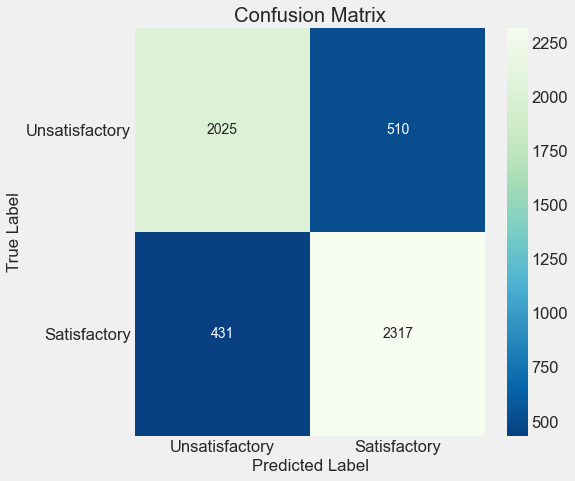

,Accuracy,F1,Recall,Precision
0,0.821882,0.831211,0.843159,0.819597


time: 779 ms


In [153]:
%%capture --no-display
f.confusion_report_nn(nn_svsi, X_test, y_test)

## Model Summary 4

In [154]:
modeling.history

,Name,Accuracy,F1,Recall,Precision,CV_Time(sec),Notes
0,Baseline,0.534504,0.000000,0.000000,0.000000,0.355226,Baseline DummyCFL
1,dt,0.540998,0.479229,0.453838,0.507737,2.154067,Decision Tree
2,ada,0.548453,0.502650,0.490355,0.515801,12.718576,AdaBoost
3,bclf,0.555173,0.505450,0.488414,0.523763,14.089840,Bagging CLF
4,knn,0.562853,0.520530,0.509767,0.531792,9.156851,KNN
5,rf,0.569743,0.526307,0.513526,0.539816,17.938879,Random Forest
6,xgb,0.589224,0.542735,0.523957,0.563241,3.612580,XGBoost
7,svc,0.610515,0.557890,0.528084,0.591627,83.341147,Support Vector Classifier
8,fsm,0.613508,0.558475,0.525296,0.596267,0.375140,FSM Naive Bayes
9,logreg,0.614694,0.556807,0.520078,0.599264,7.526850,Logistic Regression


time: 12.1 ms


In [155]:
# df = modeling.history
# f.df_plot(df, 'modeling_history')

time: 751 µs


# Adding Assessment Data

In [156]:
path = os.path.join(gparent, 'data/processed/df1.csv')
df = pd.read_csv(path)

time: 136 ms


In [157]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24792 entries, 0 to 24791
Data columns (total 28 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   target                      24792 non-null  int64  
 1   row_id                      24792 non-null  object 
 2   code_module                 24792 non-null  object 
 3   code_presentation           24792 non-null  object 
 4   id_student                  24792 non-null  int64  
 5   gender                      24792 non-null  object 
 6   region                      24792 non-null  object 
 7   highest_education           24792 non-null  object 
 8   imd_band                    24792 non-null  object 
 9   age_band                    24792 non-null  object 
 10  num_of_prev_attempts        24792 non-null  int64  
 11  studied_credits             24792 non-null  int64  
 12  disability                  24792 non-null  object 
 13  final_result                247

In [158]:
drops = ['row_id', 'code_module', 'code_presentation',
         'id_student', 'final_result', 'date']
df = df.drop(drops, axis=1)

time: 8.39 ms


In [159]:
# fixing typo
df['imd_band'] = df['imd_band'].replace(['10-20'], '10-20%')
# renaming values
df['disability'] = df['disability'].replace(['Y', 'N'], ['Yes', 'No'])
df['gender'] = df['gender'].replace(['M', 'F'], ['Male', 'Female'])

time: 15.9 ms


In [160]:
df.head()

,target,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,id_assessment,...,score,assessment_type,weight,id_site,sum_click,module_presentation_length,mean_score,adjusted_score,click_sum,num_activities
0,1,Male,Yorkshire Region,A Level or Equivalent,20-30%,0-35,0,60,No,1752,...,63,TMA,10.0,546614,3,268,68.4,6.3,3720,1215
1,1,Male,South Region,Lower Than A Level,80-90%,35-55,0,60,No,1752,...,84,TMA,10.0,546614,19,268,72.6,8.4,20520,4565
2,1,Male,North Western Region,A Level or Equivalent,30-40%,0-35,0,60,No,1752,...,80,TMA,10.0,546614,9,268,78.0,8.0,9720,3905
3,1,Male,London Region,HE Qualification,60-70%,0-35,0,60,No,1752,...,76,TMA,10.0,546614,4,268,76.6,7.6,5750,1565
4,1,Female,London Region,Lower Than A Level,30-40%,35-55,0,60,No,1752,...,73,TMA,10.0,546614,13,268,70.0,7.3,9480,2860


time: 32 ms


In [161]:
df.describe()

,target,num_of_prev_attempts,studied_credits,id_assessment,date_submitted,is_banked,score,weight,id_site,sum_click,module_presentation_length,mean_score,adjusted_score,click_sum,num_activities
count,24792.000000,24792.000000,24792.000000,24792.000000,24792.000000,24792.000000,24792.000000,24792.000000,2.479200e+04,24792.000000,24792.000000,24792.000000,24792.000000,24792.000000,24792.000000
mean,0.553848,0.117377,77.026864,25846.887504,45.650895,0.019442,77.930703,4.190707,7.654642e+05,2.905332,255.869071,72.606214,3.195963,14668.596402,3849.265207
std,0.497102,0.410642,38.459296,8819.319309,48.832363,0.138074,23.112562,5.486193,1.487231e+05,3.856240,13.267249,16.396490,4.471007,22065.223483,4930.773566
min,0.000000,0.000000,30.000000,1752.000000,-10.000000,0.000000,0.000000,0.000000,5.267210e+05,1.000000,234.000000,0.000000,0.000000,1.000000,1.000000
25%,0.000000,0.000000,60.000000,15020.000000,20.000000,0.000000,68.000000,0.000000,6.735190e+05,1.000000,241.000000,64.454545,0.000000,2014.500000,690.000000
50%,1.000000,0.000000,60.000000,25355.000000,25.000000,0.000000,82.000000,2.000000,7.683300e+05,1.000000,262.000000,76.000000,1.000000,6200.000000,1999.000000
75%,1.000000,0.000000,90.000000,34878.000000,56.000000,0.000000,97.250000,10.000000,8.969380e+05,3.000000,268.000000,84.400000,5.000000,17316.000000,5076.000000
max,1.000000,6.000000,630.000000,37439.000000,608.000000,1.000000,100.000000,100.000000,1.046866e+06,174.000000,269.000000,100.000000,84.000000,339168.000000,76668.000000


time: 59.9 ms


## Creating Holdout Data

In [162]:
# splitting data & target
X, y = f.X_y(df)

time: 6.85 ms


In [163]:
# splitting traing and holdout data
X_training, X_holdout, y_training, y_holdout = f.test_train(X, y)

time: 17.9 ms


## Creating Training Data

In [164]:
# train test split
X_train, X_test, y_train, y_test = f.test_train(X_training, y_training)

time: 16.1 ms


## Naive Bayes Classifier

In [165]:
mnb_assess = make_pipeline(preprocessing_mm, mnb)

time: 1.07 ms


### Fitting Model

In [166]:
mnb_assess.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10ad70190>),
                                                 ('minmaxscaler',
                                                  MinMaxScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10ad70040>)])),
                ('multinomialnb', MultinomialNB())])

time: 76.8 ms


### Saving Model

In [167]:
# f.pickle_model(mnb_assess, 'mnb_assess')

time: 1.18 ms


### Cross Val Scores

In [168]:
# checking cross val scores
modeling.report(mnb_assess, X_train, y_train, 'mnb_assess',\
                'Naive Bayes SVSI/MinMax()')

mnb_assess has an average Accuracy of 0.6561491574040875
mnb_assess has an average F1 of 0.7132832874446526
mnb_assess has an average Recall of 0.7722392139108271
mnb_assess has an average Precision of 0.6626980960011107
time: 457 ms


### Test Data Confusion Matrix

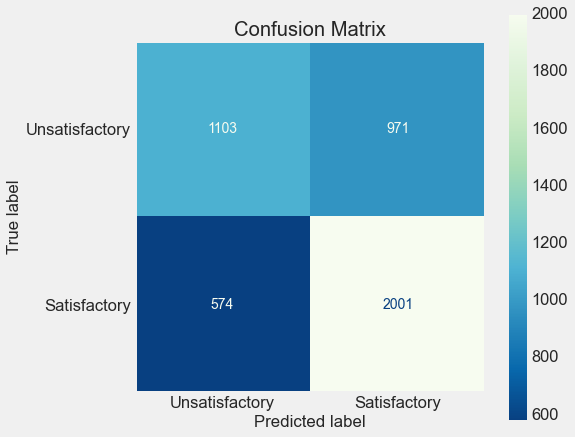

,Accuracy,F1,Recall,Precision
0,0.66767,0.721471,0.777087,0.673284


time: 411 ms


In [169]:
f.confusion_report(mnb_assess, X_test, y_test)

## KNeighborsClassifier

In [170]:
knn_assess = make_pipeline(preprocessing_mm, KNN)

time: 954 µs


### Fitting Model

In [171]:
knn_assess.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10ad70190>),
                                                 ('minmaxscaler',
                                                  MinMaxScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10ad70040>)])),
                ('kneighborsclassifier', KNeighborsClassifier(n_jobs=-1))])

time: 72.2 ms


In [172]:
# f.pickle_model(knn_assess, 'knn_assess')

time: 771 µs


### Cross Val Scores

In [173]:
# checking cross val scores
modeling.report(knn_assess, X_train, y_train, 'knn_assess',\
                'KNN SVSI/MinMax()')

knn_assess has an average Accuracy of 0.6337038365005379
knn_assess has an average F1 of 0.6868341069865143
knn_assess has an average Recall of 0.7253630296627932
knn_assess has an average Precision of 0.6522905672674613
time: 6.59 s


### Test Data Confusion Matrix

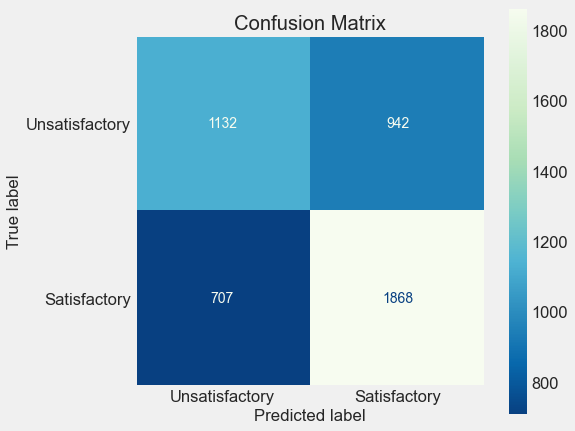

,Accuracy,F1,Recall,Precision
0,0.6453,0.693779,0.725437,0.664769


time: 12.2 s


In [174]:
f.confusion_report(knn_assess, X_test, y_test)

## Logistic Regression Classifier

In [175]:
logreg_assess = make_pipeline(preprocessing_mm, LR)

time: 893 µs


### Fitting Model

In [176]:
logreg_assess.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10ad70190>),
                                                 ('minmaxscaler',
                                                  MinMaxScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10ad70040>)])),
                ('logisticregression',
                 LogisticRegression(max_iter=1000, n_jobs=-1,
                                    random_state=2021))])

time: 1.23 s


In [177]:
# f.pickle_model(logreg_assess, 'logreg_assess')

time: 658 µs


### Cross Val Scores

In [178]:
# checking cross val scores
modeling.report(logreg_assess, X_train, y_train, 'logreg_assess',\
                'LogReg SVSI/MinMax()')

logreg_assess has an average Accuracy of 0.776980996773037
logreg_assess has an average F1 of 0.8054189837695173
logreg_assess has an average Recall of 0.8334857554873653
logreg_assess has an average Precision of 0.7792364469051705
time: 4.98 s


### Test Data Confusion Matrix

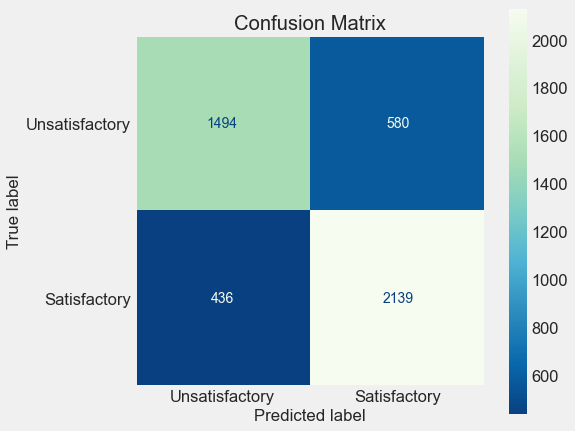

,Accuracy,F1,Recall,Precision
0,0.781458,0.808085,0.83068,0.786686


time: 381 ms


In [179]:
f.confusion_report(logreg_assess, X_test, y_test)

## Support Vector Machine

In [180]:
svc_assess= make_pipeline(preprocessing_mm, SVC)

time: 908 µs


### Fitting Model

In [181]:
svc_assess.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10ad70190>),
                                                 ('minmaxscaler',
                                                  MinMaxScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10ad70040>)])),
                ('svc', SVC())])

time: 8.99 s


In [182]:
# f.pickle_model(svc_assess, 'svc_assess')

time: 603 µs


### Cross Val Scores

In [183]:
# checking cross val scores
modeling.report(svc_assess, X_train, y_train, 'svc_assess',\
                'Support Vector CLF SVSI/MinMax()')

svc_assess has an average Accuracy of 0.7713875941197562
svc_assess has an average F1 of 0.8062032977269631
svc_assess has an average Recall of 0.8586060667035564
svc_assess has an average Precision of 0.7598341104961492
time: 45.7 s


### Test Data Confusion Matrix

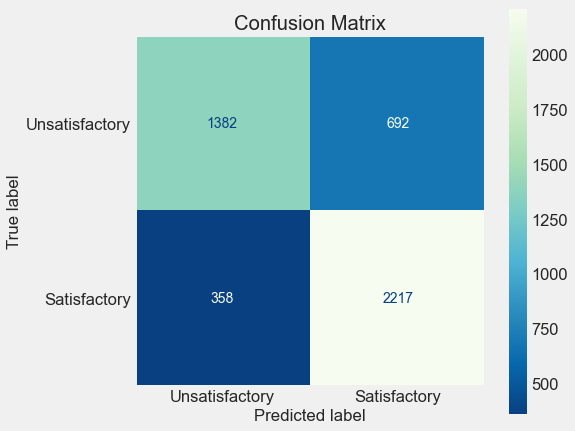

,Accuracy,F1,Recall,Precision
0,0.774145,0.808534,0.860971,0.762118


time: 36.5 s


In [184]:
f.confusion_report(svc_assess, X_test, y_test)

## Linear Support Vector Machine

In [185]:
lsvc_assess = make_pipeline(preprocessing_mm, LSVC)

time: 898 µs


### Fitting Model

In [186]:
lsvc_assess.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10ad70190>),
                                                 ('minmaxscaler',
                                                  MinMaxScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10ad70040>)])),
                ('linearsvc', LinearSVC())])

time: 366 ms


In [187]:
# f.pickle_model(lsvc_assess, 'lsvc_assess')

time: 581 µs


### Cross Val Scores

In [188]:
# checking cross val scores
modeling.report(lsvc_assess, X_train, y_train, 'lsvc_assess',\
                'Linear SVC SVSI/MinMax()')

lsvc_assess has an average Accuracy of 0.7809250627465041
lsvc_assess has an average F1 of 0.8084376723066086
lsvc_assess has an average Recall of 0.8347799185069672
lsvc_assess has an average Precision of 0.783752912543715
time: 1.81 s


### Test Data Confusion Matrix

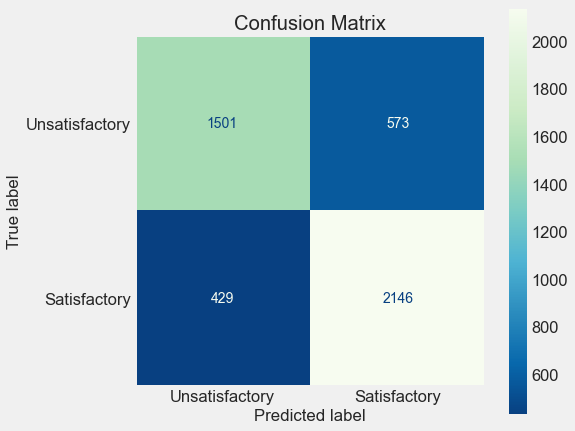

,Accuracy,F1,Recall,Precision
0,0.78447,0.810729,0.833398,0.789261


time: 341 ms


In [189]:
f.confusion_report(lsvc_assess, X_test, y_test)

## Decision Tree

In [190]:
dt_assess = make_pipeline(preprocessing_mm, DT)

time: 1.01 ms


### Fitting Model

In [191]:
dt_assess.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10ad70190>),
                                                 ('minmaxscaler',
                                                  MinMaxScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10ad70040>)])),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(random_state=2021))])

time: 201 ms


In [192]:
# f.pickle_model(dt_assess, 'dt_assess')

time: 612 µs


### Cross Val Scores

In [193]:
# checking cross val scores
modeling.report(dt_assess, X_train, y_train, 'dt_assess',\
                'Decision Tree CLF SVSI/MinMax()')

dt_assess has an average Accuracy of 0.810828253854428
dt_assess has an average F1 of 0.8291092778476216
dt_assess has an average Recall of 0.8286956922715764
dt_assess has an average Precision of 0.8295831231510311
time: 823 ms


### Test Data Confusion Matrix

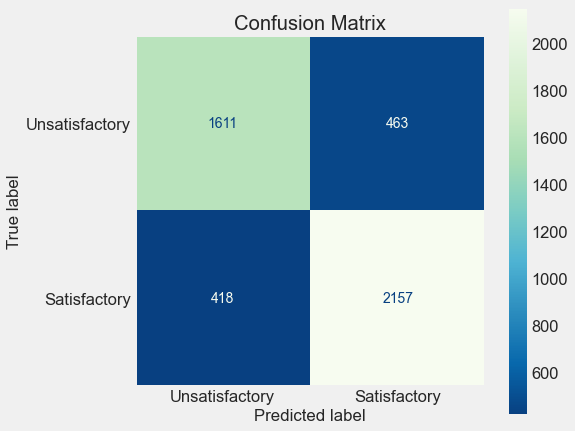

,Accuracy,F1,Recall,Precision
0,0.810497,0.830414,0.83767,0.823282


time: 223 ms


In [194]:
f.confusion_report(dt_assess, X_test, y_test)

## Bagging Classifier

In [195]:
bclf_assess = make_pipeline(preprocessing_mm, BCLF)

time: 814 µs


### Fitting Model

In [196]:
bclf_assess.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10ad70190>),
                                                 ('minmaxscaler',
                                                  MinMaxScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10ad70040>)])),
                ('baggingclassifier',
                 BaggingClassifier(base_estimator=DecisionTreeClassifier(random_state=2021),
                                   random_state=2021))])

time: 943 ms


In [197]:
# f.pickle_model(bclf_assess, 'bclf_assess')

time: 602 µs


### Cross Val Scores

In [198]:
# checking cross val scores
modeling.report(bclf_assess, X_train, y_train, 'bclf_assess',\
                'Bagging CLF SVSI/MinMax()')

bclf_assess has an average Accuracy of 0.8490498386518466
bclf_assess has an average F1 of 0.8639248333909197
bclf_assess has an average Recall of 0.865337877492161
bclf_assess has an average Precision of 0.8626118391110822
time: 3.58 s


### Test Data Confusion Matrix

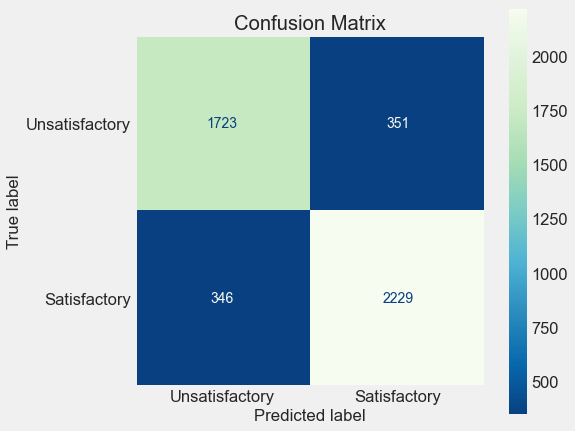

,Accuracy,F1,Recall,Precision
0,0.850075,0.864791,0.865631,0.863953


time: 278 ms


In [199]:
f.confusion_report(bclf_assess, X_test, y_test)

## Random Forest Classifier

In [200]:
rf_assess = make_pipeline(preprocessing_mm, RF)

time: 845 µs


### Fitting Model

In [201]:
rf_assess.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10ad70190>),
                                                 ('minmaxscaler',
                                                  MinMaxScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10ad70040>)])),
                ('randomforestclassifier',
                 RandomForestClassifier(n_jobs=-1, random_state=2021))])

time: 639 ms


In [202]:
# f.pickle_model(rf_assess, 'rf_assess')

time: 660 µs


### Cross Val Scores

In [203]:
# checking cross val scores
modeling.report(rf_assess, X_train, y_train, 'rf_assess',\
                'Random Forest SVSI/MinMax()')

rf_assess has an average Accuracy of 0.8611688777339548
rf_assess has an average F1 of 0.8786184947156741
rf_assess has an average Recall of 0.9072920334691551
rf_assess has an average Precision of 0.8518193696531455
time: 4.32 s


### Test Data Confusion Matrix

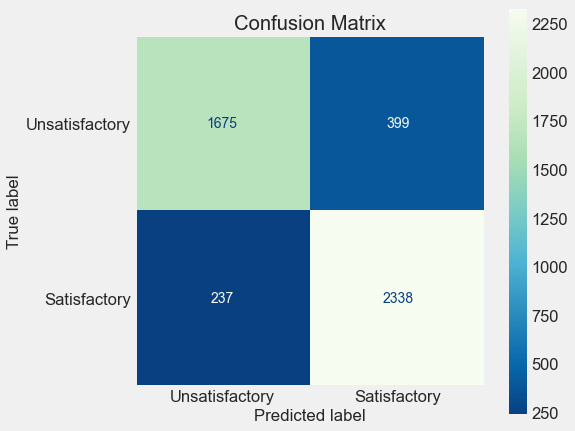

,Accuracy,F1,Recall,Precision
0,0.863196,0.880271,0.907961,0.85422


time: 435 ms


In [204]:
f.confusion_report(rf_assess, X_test, y_test)

## AdaBoost

In [205]:
ada_assess = make_pipeline(preprocessing_mm, ADA)

time: 910 µs


### Fitting Model

In [206]:
ada_assess.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10ad70190>),
                                                 ('minmaxscaler',
                                                  MinMaxScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10ad70040>)])),
                ('adaboostclassifier',
                 AdaBoostClassifier(base_estimator=DecisionTreeClassifier(random_state=2021),
                                    random_state=2021))])

time: 211 ms


In [207]:
# f.pickle_model(ada_assess, 'ada_assess')

time: 672 µs


### Cross Val Scores

In [208]:
# checking cross val scores
modeling.report(ada_assess, X_train, y_train, 'ada_assess',\
                'AdaBoost SVSI/MinMax()')

ada_assess has an average Accuracy of 0.8118321979204015
ada_assess has an average F1 of 0.8296304334721898
ada_assess has an average Recall of 0.8272693126750174
ada_assess has an average Precision of 0.8320549730148119
time: 816 ms


### Test Data Confusion Matrix

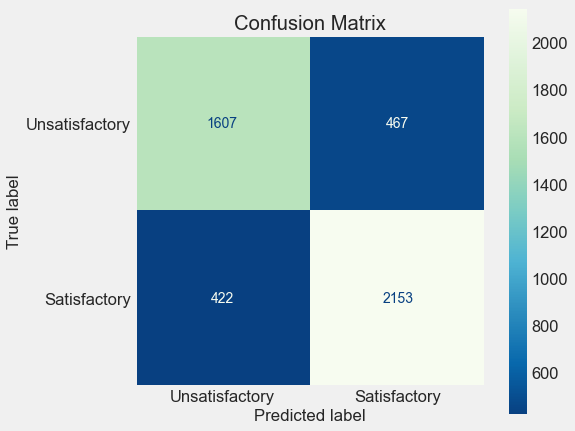

,Accuracy,F1,Recall,Precision
0,0.808776,0.828874,0.836117,0.821756


time: 220 ms


In [209]:
f.confusion_report(ada_assess, X_test, y_test)

## XGBoost

In [210]:
xgb_assess = make_pipeline(preprocessing_mm, XGB)

time: 947 µs


### Fitting Model

In [211]:
%%capture --no-display
xgb_assess.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10ad70190>),
                                                 ('minmaxscaler',
                                                  MinMaxScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10ad70040>)])),
                ('xgbclassifier',
                 XGBClassifier(ba...
                               importance_type='gain',
                               interaction_constraints='',
                               learning_rate=0.300000012, max_delta_step=0,
                               max_depth=6, min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estima

time: 2 s


In [212]:
# f.pickle_model(xgb_assess, 'xgb_assess')

time: 1.13 ms


### Cross Val Scores

In [213]:
%%capture --no-display
# checking cross val scores
modeling.report(xgb_assess, X_train, y_train, 'xgb_assess', 'XGBoost SVSI/MinMax()')

time: 8.58 s


### Test Data Confusion Matrix

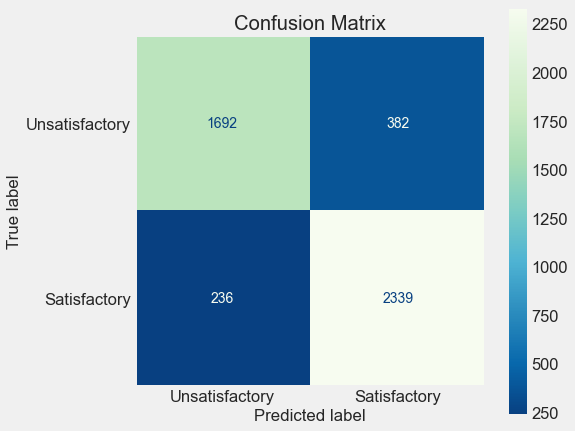

,Accuracy,F1,Recall,Precision
0,0.867068,0.883308,0.90835,0.85961


time: 371 ms


In [214]:
%%capture --no-display
f.confusion_report(xgb_assess, X_test, y_test)

## Model Summary 5

In [215]:
modeling.history

,Name,Accuracy,F1,Recall,Precision,CV_Time(sec),Notes
0,Baseline,0.534504,0.000000,0.000000,0.000000,0.355226,Baseline DummyCFL
1,dt,0.540998,0.479229,0.453838,0.507737,2.154067,Decision Tree
2,ada,0.548453,0.502650,0.490355,0.515801,12.718576,AdaBoost
3,bclf,0.555173,0.505450,0.488414,0.523763,14.089840,Bagging CLF
4,knn,0.562853,0.520530,0.509767,0.531792,9.156851,KNN
5,rf,0.569743,0.526307,0.513526,0.539816,17.938879,Random Forest
6,xgb,0.589224,0.542735,0.523957,0.563241,3.612580,XGBoost
7,svc,0.610515,0.557890,0.528084,0.591627,83.341147,Support Vector Classifier
8,fsm,0.613508,0.558475,0.525296,0.596267,0.375140,FSM Naive Bayes
9,logreg,0.614694,0.556807,0.520078,0.599264,7.526850,Logistic Regression


time: 23.8 ms


## Voting Classifier
Using the top three model in a voting classifier.

In [216]:
clf1 = LR
clf2 = RF
clf3 = XGB

estimators = [('lsvs',clf1), ('logreg', clf1), ('rf', clf2), ('xgb', clf3)]

VC = VotingClassifier(estimators=estimators, voting='hard', n_jobs=-1)

time: 1.22 ms


In [217]:
vc_assess = make_pipeline(preprocessing_mm, VC)

time: 1.05 ms


### Fitting Model

In [218]:
%%capture --no-display
vc_assess.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10ad70190>),
                                                 ('minmaxscaler',
                                                  MinMaxScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10ad70040>)])),
                ('votingclassifier',
                 VotingClassif...
                                                             interaction_constraints='',
                                                             learning_rate=0.300000012,
                                                             max_delta_step=0,
                                                             max_depth=6,
   

time: 4.1 s


In [219]:
# f.pickle_model(vc_assess, 'vc_assess')

time: 610 µs


### Cross Val Scores

In [220]:
%%capture --no-display
# checking cross val scores
modeling.report(vc_assess, X_train, y_train, 'vc_assess', 'Voting CLF SVSI/MinMax()')

time: 16.1 s


### Test Data Confusion Matrix

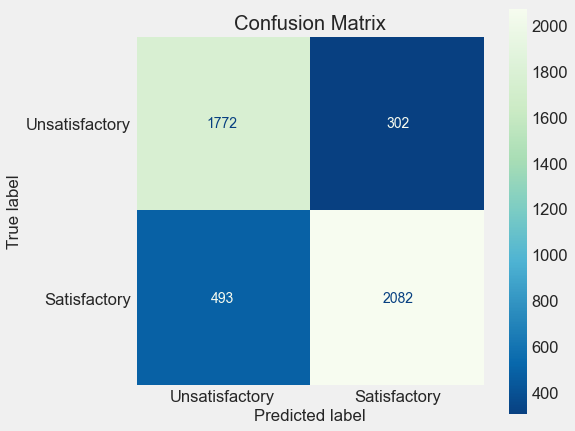

,Accuracy,F1,Recall,Precision
0,0.828995,0.839685,0.808544,0.873322


time: 815 ms


In [221]:
%%capture --no-display
f.confusion_report(vc_assess, X_test, y_test)

## Model Summary 6

In [222]:
modeling.history

,Name,Accuracy,F1,Recall,Precision,CV_Time(sec),Notes
0,Baseline,0.534504,0.000000,0.000000,0.000000,0.355226,Baseline DummyCFL
1,dt,0.540998,0.479229,0.453838,0.507737,2.154067,Decision Tree
2,ada,0.548453,0.502650,0.490355,0.515801,12.718576,AdaBoost
3,bclf,0.555173,0.505450,0.488414,0.523763,14.089840,Bagging CLF
4,knn,0.562853,0.520530,0.509767,0.531792,9.156851,KNN
5,rf,0.569743,0.526307,0.513526,0.539816,17.938879,Random Forest
6,xgb,0.589224,0.542735,0.523957,0.563241,3.612580,XGBoost
7,svc,0.610515,0.557890,0.528084,0.591627,83.341147,Support Vector Classifier
8,fsm,0.613508,0.558475,0.525296,0.596267,0.375140,FSM Naive Bayes
9,logreg,0.614694,0.556807,0.520078,0.599264,7.526850,Logistic Regression


time: 26.5 ms


## Neural Network

In [223]:
def create_model():
    # building model
    model = Sequential()
    model.add(Dense(64, input_dim=52, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    # compiling
    model.compile(loss='binary_crossentropy',
                 optimizer='adam',
                 metrics=['accuracy'])
    return model

time: 1.11 ms


In [224]:
NN2 = KerasClassifier(build_fn=create_model,
                     epochs=10,
                     batch_size=32,
                     verbose=0)

time: 1.26 ms


### Pipeline

In [225]:
nn_assess = make_pipeline(preprocessing_mm, NN2)

time: 952 µs


### Fitting Models

In [226]:
%%capture --no-display
nn_assess.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10ad70190>),
                                                 ('minmaxscaler',
                                                  MinMaxScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10ad70040>)])),
                ('kerasclassifier',
                 <tensorflow.python.keras.wrappers.scikit_learn.KerasClassifier object at 0x1840b28b0>)])

time: 4.06 s


In [227]:
# f.pickle_model(nn_assess, 'nn_assess')

time: 704 µs


### Cross Val Scores

In [228]:
%%capture --no-display
modeling.report(nn_assess, X_train, y_train, 'nn_assess',\
                'Neural Net SVSI/MinMax()')

time: 17.3 s


### Test Data Confusion Matrix

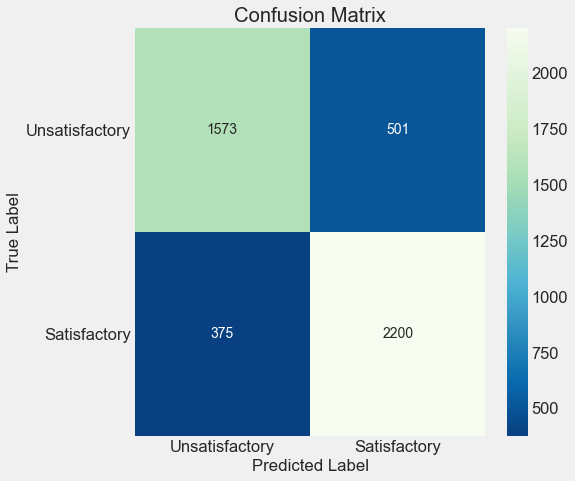

,Accuracy,F1,Recall,Precision
0,0.811572,0.833965,0.854369,0.814513


time: 665 ms


In [229]:
%%capture --no-display
f.confusion_report_nn(nn_assess, X_test, y_test)

## Model Summary 7

In [230]:
modeling.history

,Name,Accuracy,F1,Recall,Precision,CV_Time(sec),Notes
0,Baseline,0.534504,0.000000,0.000000,0.000000,0.355226,Baseline DummyCFL
1,dt,0.540998,0.479229,0.453838,0.507737,2.154067,Decision Tree
2,ada,0.548453,0.502650,0.490355,0.515801,12.718576,AdaBoost
3,bclf,0.555173,0.505450,0.488414,0.523763,14.089840,Bagging CLF
4,knn,0.562853,0.520530,0.509767,0.531792,9.156851,KNN
5,rf,0.569743,0.526307,0.513526,0.539816,17.938879,Random Forest
6,xgb,0.589224,0.542735,0.523957,0.563241,3.612580,XGBoost
7,svc,0.610515,0.557890,0.528084,0.591627,83.341147,Support Vector Classifier
8,fsm,0.613508,0.558475,0.525296,0.596267,0.375140,FSM Naive Bayes
9,logreg,0.614694,0.556807,0.520078,0.599264,7.526850,Logistic Regression


time: 19.4 ms


In [231]:
Audio(sound_file, autoplay=True)

time: 6.5 ms
[17:30:42] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:30:49] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:30:54] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:34:23] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to resto

In [241]:
# ma_df = modeling.history
# f.df_plot(ma_df, 'modeling_history')

time: 1.05 ms
